Support Vector Machines (SVM) beschreiben eine ML-Methode für Supervised Learning.

Auslesen & Vorbereitung des Datensatzes (u.a. Vorbereitung der Test-/Trainingsdatensätze)

In [1]:
import pandas as pd

dataset = pd.read_csv("lung_cancer_dataset.csv")

# Convert text to categorical data
dataset['gender'] = dataset['gender'].astype('category')
dataset['radon_exposure'] = dataset['radon_exposure'].astype('category')
dataset['alcohol_consumption'] = dataset['alcohol_consumption'].fillna('None').astype('category')

dataset['asbestos_exposure'] = dataset['asbestos_exposure'].map({'Yes': True, 'No': False})
dataset['secondhand_smoke_exposure'] = dataset['secondhand_smoke_exposure'].map({'Yes': True, 'No': False})
dataset['copd_diagnosis'] = dataset['copd_diagnosis'].map({'Yes': True, 'No': False})
dataset['family_history'] = dataset['family_history'].map({'Yes': True, 'No': False})
dataset['lung_cancer'] = dataset['lung_cancer'].map({'Yes': True, 'No': False})

# no duplicate rows
dataset.duplicated().sum()

# show data
dataset.head()

,patient_id,age,gender,pack_years,radon_exposure,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,alcohol_consumption,family_history,lung_cancer
0,100000,69,Male,66.025244,High,False,False,True,Moderate,False,False
1,100001,32,Female,12.780800,High,False,True,True,Moderate,True,True
2,100002,89,Female,0.408278,Medium,True,True,True,None,False,True
3,100003,78,Female,44.065232,Low,False,True,False,Moderate,False,True
4,100004,38,Female,44.432440,Medium,True,False,True,None,True,True


In [2]:
from sklearn.model_selection import train_test_split

# get the data and target from the data frame 
data = dataset.loc[:, 'age':'family_history']
target = dataset['lung_cancer']

# Split the dataset into training and testing sets
train_data, test_data, train_label, test_label = train_test_split(data, target, test_size=0.2, random_state=42)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Spaltennamen nach Typ trennen
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
numeric_cols = data.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("numeric", "passthrough", numeric_cols), # RobustScaler() hat keine/kaum Auswirkung
    ("categorical", OneHotEncoder(drop='first'), categorical_cols)
])

X_processed = preprocessor.fit_transform(train_data)

# Get feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(cat_feature_names)

# Create DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
X_processed_df.head()

,age,pack_years,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,family_history,gender_Male,radon_exposure_Low,radon_exposure_Medium,alcohol_consumption_Moderate,alcohol_consumption_None
0,18,88.019382,True,False,True,False,1.0,0.0,0.0,0.0,0.0
1,84,88.506591,True,False,False,False,0.0,0.0,0.0,0.0,0.0
2,43,12.587098,False,True,True,False,0.0,0.0,1.0,0.0,0.0
3,48,33.556994,False,False,False,True,0.0,0.0,1.0,1.0,0.0
4,43,30.717066,True,True,False,False,1.0,0.0,1.0,0.0,1.0


Aufbau & Training der Pipeline mit SVC

In [4]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC()),
])

In [5]:
from sklearn.experimental import enable_halving_search_cv  # Benötigt für HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV

# Parameter-Raster definieren
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', "sigmoid", "poly"],  # precomputed kann nur mit vorgegebenen Kernel-Matrizen verwendet werden # poly dauert zu lange
    'classifier__gamma': ['auto', 'scale', 0, 0.1, 0.3, 0.5, 0.7, 1],  # gamma nur für rbf/poly/sigmoid
    #'classifier__class_weight': ['balanced', None], # balanciert ungleiche Klassenverteilungen aus // nicht sinnvoll, weil es sich um einen ausgewogenen Datensatz handelt
    'classifier__degree': [2, 3, 4], # nur für poly // steuert Grad der Polynomfunktion
    'classifier__coef0': [0.0, 0.1, 0.5], # poly/sigmoid // steuert Einfluss von höherwertigen vs. niederwertigen Merkmalen (Form des Kernels)
    #'classifier__shrinking': [True, False], # ob Shrinking-Algorithmus verwendet wird // unwichtige Vektoren werden entfernt, um Training zu beschleunigen
    #'classifier__probability': [True, False], # ob Wahrscheinlichkeiten geschätzt werden (langsamer) // macht logitistische Regression
    #'classifier__tol': [1e-3, 1e-4] # Toleranz für die Optimierung
}

# HalvingGridSearchCV mit SVM - deutlich schneller als GridSearchCV
halving_search = HalvingGridSearchCV(
    svc_pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2,
    factor=3,  # Faktor für die schrittweise Reduzierung (1/3 bleiben in jeder Iteration)
    min_resources='smallest',  # Automatische Bestimmung der minimalen Ressourcen
    max_resources='auto',  # Automatische Bestimmung der maximalen Ressourcen
    aggressive_elimination=False,  # Konservativere Elimination für bessere Ergebnisse
    random_state=0,
) 
# HalvingGridSearchCV startet mit wenigen Samples/Kandidaten und steigert sich schrittweise
# Nur die besten Parameter-Kombinationen werden mit mehr Ressourcen getestet
halving_search.fit(train_data, train_label)

# Beste Parameter und Modell
print("Beste Parameter:", halving_search.best_params_)
best_model = halving_search.best_estimator_

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 20
max_resources_: 40000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1440
n_resources: 20
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[CV] END classifier__C=0.01, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=auto, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=auto, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=auto, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=auto, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=auto, classifier__kernel=linear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=auto, classifier__kernel=rbf; total time=   0.0s
[CV] END classifier__C=0.01, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=auto, classifier__kernel=rbf; total time=   0.0s
[

Auswertung des besten Modells

In [6]:
print("Bestes Modell:", best_model)
print("Beste Parameter:", halving_search.best_params_)

Bestes Modell: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['age', 'pack_years',
                                                   'asbestos_exposure',
                                                   'secondhand_smoke_exposure',
                                                   'copd_diagnosis',
                                                   'family_history']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'radon_exposure',
                                                   'alcohol_consumption'])])),
                ('classifier', SVC(C=100, coef0=0.5, degree=2, kernel='poly'))])
Beste Parameter: {'classifier__C': 100, 'classifier__coef0': 0.5, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classif

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

y_pred_train = best_model.predict(train_data)
y_pred_test = best_model.predict(test_data)

print("--- Modellbewertung ---")
print("Trainingsdaten")
print("Accuracy Trainingsdaten:", accuracy_score(train_label, y_pred_train))
print("F1-Score Trainingsdaten:", f1_score(train_label, y_pred_train))
print("Precision Trainingsdaten:", precision_score(train_label, y_pred_train))
print("Recall Trainingsdaten:", recall_score(train_label, y_pred_train))

print("\nTestdaten")
print("Accuracy Testdaten:", accuracy_score(test_label, y_pred_test))
print("F1-Score Testdaten:", f1_score(test_label, y_pred_test))
print("Precision Testdaten:", precision_score(test_label, y_pred_test))
print("Recall Testdaten:", recall_score(test_label, y_pred_test))

print("Confusion Matrix:\n", confusion_matrix(test_label, y_pred_test))

--- Modellbewertung ---
Trainingsdaten
Accuracy Trainingsdaten: 0.7298
F1-Score Trainingsdaten: 0.8264890030502489
Precision Trainingsdaten: 0.7395139048494599
Recall Trainingsdaten: 0.9366494432719599

Testdaten
Accuracy Testdaten: 0.73
F1-Score Testdaten: 0.8265227447956823
Precision Testdaten: 0.7408431237042156
Recall Testdaten: 0.934612031386225
Confusion Matrix:
 [[ 868 2250]
 [ 450 6432]]


In [8]:
from sklearn.metrics import classification_report

print("\nKlassifikationsbericht Trainingsdaten:")
print(classification_report(train_label, y_pred_train))

print("\nKlassifikationsbericht Testdaten:")
print(classification_report(test_label, y_pred_test))


Klassifikationsbericht Trainingsdaten:
              precision    recall  f1-score   support

       False       0.66      0.28      0.39     12518
        True       0.74      0.94      0.83     27482

    accuracy                           0.73     40000
   macro avg       0.70      0.61      0.61     40000
weighted avg       0.72      0.73      0.69     40000


Klassifikationsbericht Testdaten:
              precision    recall  f1-score   support

       False       0.66      0.28      0.39      3118
        True       0.74      0.93      0.83      6882

    accuracy                           0.73     10000
   macro avg       0.70      0.61      0.61     10000
weighted avg       0.72      0.73      0.69     10000



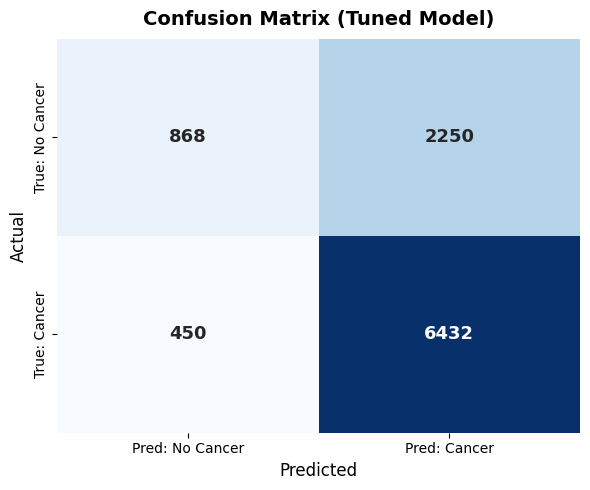

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
 
cm = confusion_matrix(test_label, best_model.predict(test_data))
 
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: No Cancer', 'Pred: Cancer'],
            yticklabels=['True: No Cancer', 'True: Cancer'],
            cbar=False,  # remove colorbar for cleaner look
            annot_kws={"size": 13, "weight": "bold"})  # makes numbers clearer
 
plt.title("Confusion Matrix (Tuned Model)", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()
 

/tmp/ipykernel_11536/2321951205.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


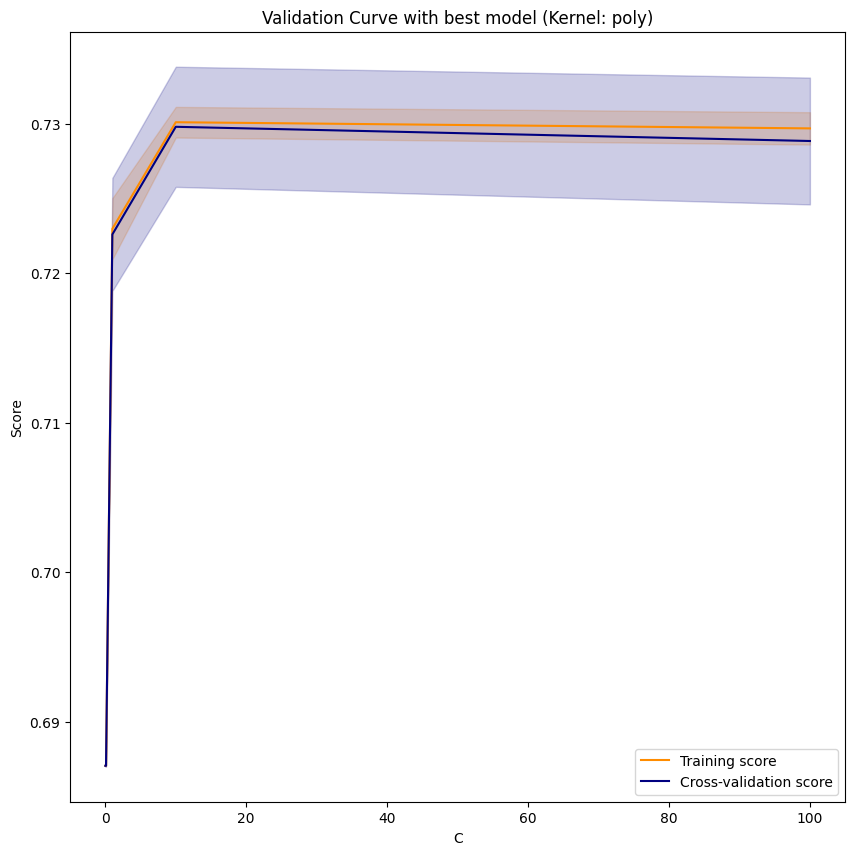

In [11]:
from sklearn.model_selection import validation_curve

# collect data for plotting
train_scores, valid_scores = validation_curve(
    best_model, 
    X=train_data, 
    y=train_label, 
    param_name='classifier__C', 
    param_range=param_grid['classifier__C'], 
    cv=5
)

# Ergebnisse als DataFrame
results = pd.DataFrame(halving_search.cv_results_)

# Beispiel: Vergleich der Kernels bei verschiedenen C-Werten
kernels = results['param_classifier__kernel'].unique()
c_values = results['param_classifier__C'].unique()

# first, calculate the means and standard deviations
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

# create the figure
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(c_values, train_scores_mean, label="Training score", color="darkorange")
ax.fill_between(
    c_values,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    color="darkorange",
    alpha=0.2
)

ax.plot(c_values, valid_scores_mean, label="Cross-validation score", color="navy")
ax.fill_between(
    c_values,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    color="navy",
    alpha=0.2
)

ax.set(
    title=f"Validation Curve with best model (Kernel: {best_model.named_steps['classifier'].kernel})",
    xlabel="C",
    ylabel="Score"
)
ax.legend(loc="best")
fig.show()

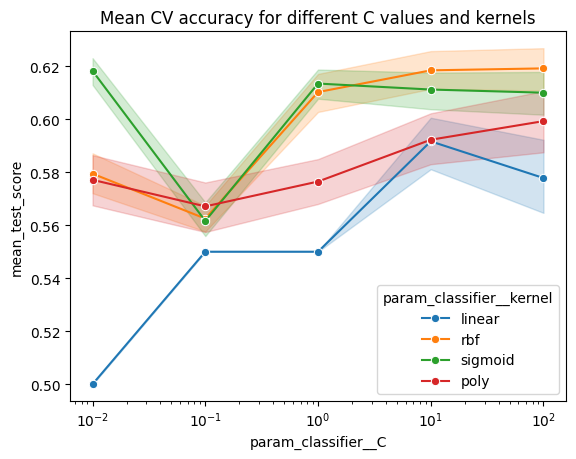

In [12]:
import seaborn as sns
import pandas as pd

results = pd.DataFrame(halving_search.cv_results_)
sns.lineplot(
    data=results,
    x="param_classifier__C",
    y="mean_test_score",
    hue="param_classifier__kernel",
    marker="o"
)
plt.title("Mean CV accuracy for different C values and kernels")
plt.xscale("log")
plt.show()